# Wyjaśnialne uczenie maszynowe – praca domowa 1

### Katarzyna Koprowska

In [1]:
import pandas as pd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt

## Wczytanie danych

Wykorzystanym zbirem danych jest Home Equity (HMEQ), zawierający informacje o 5960 klientach banku, którzy otrzymali kredyty hipoteczne.

Na podstawie zbioru próbowałam przewidzieć prawdopodobieństwo **defaultu**, czyli faktu, że klient będzie zalegał z płatnościami – określa to binarna zmienna **BAD** (1 oznacza default). Pozostałe 12 zmiennych opisuje m.in. historię kredytową aplikującego, historię zawodową oraz charakterystyki obecnej pożyczki. 

Więcej informacji na temat danych można znaleźć pod linkiem https://www.kaggle.com/ajay1735/hmeq-data 

In [4]:
hmeq = pd.read_csv("hmeq.csv", error_bad_lines=False)

In [5]:
hmeq_info = {'BAD' : 'client defaulted on loan 0 = loan repaid',
"LOAN" : "Amount of the loan request",
"MORTDUE" : "Amount due on existing mortgage",
"VALUE": "Value of current property",
"REASON": "DebtCon debt consolidation HomeImp = home improvement",
"JOBS" : "occupational categories",
"YOJ": "Years at present job",
"DEROG" : "Number of major derogatory reports",
"DELINQ": "Number of delinquent credit lines",
"CLAGE": "Age of oldest trade line in months",
"NINQ": "Number of recent credit lines",
"CLNO": "Number of credit lines",
"DEBTINC" : "Debt-to-income ratio"}

## Wstępna analiza danych

In [6]:
hmeq.shape

(5960, 13)

In [7]:
hmeq.isna().sum()/hmeq.shape[0]

BAD        0.000000
LOAN       0.000000
MORTDUE    0.086913
VALUE      0.018792
REASON     0.042282
JOB        0.046812
YOJ        0.086409
DEROG      0.118792
DELINQ     0.097315
CLAGE      0.051678
NINQ       0.085570
CLNO       0.037248
DEBTINC    0.212584
dtype: float64

In [8]:
hmeq.describe().T

,count,mean,std,min,25%,50%,75%,max
BAD,5960.0,0.199497,0.399656,0.000000,0.000000,0.000000,0.000000,1.000000
LOAN,5960.0,18607.969799,11207.480417,1100.000000,11100.000000,16300.000000,23300.000000,89900.000000
MORTDUE,5442.0,73760.817200,44457.609458,2063.000000,46276.000000,65019.000000,91488.000000,399550.000000
VALUE,5848.0,101776.048741,57385.775334,8000.000000,66075.500000,89235.500000,119824.250000,855909.000000
YOJ,5445.0,8.922268,7.573982,0.000000,3.000000,7.000000,13.000000,41.000000
DEROG,5252.0,0.254570,0.846047,0.000000,0.000000,0.000000,0.000000,10.000000
DELINQ,5380.0,0.449442,1.127266,0.000000,0.000000,0.000000,0.000000,15.000000
CLAGE,5652.0,179.766275,85.810092,0.000000,115.116702,173.466667,231.562278,1168.233561
NINQ,5450.0,1.186055,1.728675,0.000000,0.000000,1.000000,2.000000,17.000000
CLNO,5738.0,21.296096,10.138933,0.000000,15.000000,20.000000,26.000000,71.000000


## Przekształcenie danych nienumerycznych na *dummy variables*

In [9]:
from pandas.api.types import is_numeric_dtype
{column : is_numeric_dtype(hmeq[column]) for column in hmeq.columns}

{'BAD': True,
 'LOAN': True,
 'MORTDUE': True,
 'VALUE': True,
 'REASON': False,
 'JOB': False,
 'YOJ': True,
 'DEROG': True,
 'DELINQ': True,
 'CLAGE': True,
 'NINQ': True,
 'CLNO': True,
 'DEBTINC': True}

In [10]:
set(hmeq['REASON'])

{'DebtCon', 'HomeImp', nan}

In [11]:
set(hmeq['JOB'])

{'Mgr', 'Office', 'Other', 'ProfExe', 'Sales', 'Self', nan}

In [12]:
hmeq = pd.concat([hmeq, pd.get_dummies(hmeq['REASON'], prefix='REASON', dummy_na=True)],axis=1)
hmeq = pd.concat([hmeq, pd.get_dummies(hmeq['JOB'], prefix='JOB', dummy_na=True)],axis=1)
hmeq.drop(['REASON', 'JOB'],axis=1, inplace=True)

## Braki danych

In [13]:
hmeq.isna().sum()

BAD                  0
LOAN                 0
MORTDUE            518
VALUE              112
YOJ                515
DEROG              708
DELINQ             580
CLAGE              308
NINQ               510
CLNO               222
DEBTINC           1267
REASON_DebtCon       0
REASON_HomeImp       0
REASON_nan           0
JOB_Mgr              0
JOB_Office           0
JOB_Other            0
JOB_ProfExe          0
JOB_Sales            0
JOB_Self             0
JOB_nan              0
dtype: int64

### Strategia 1 – uzupełnianie braków danych średnią

In [14]:
from sklearn.impute import SimpleImputer

In [15]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

In [16]:
X = hmeq.iloc[:, 1:]
y = hmeq.loc[:, "BAD"]

In [17]:
from sklearn.model_selection import train_test_split
X_train0, X_test0, y_train0, y_test0 = train_test_split(X, y, test_size=0.35, random_state=42)
X_val0, X_test0, y_val0, y_test0 = train_test_split(X_test0, y_test0, test_size=0.6, random_state=42)

In [18]:
X_train, X_val = imp_mean.fit_transform(X_train0), imp_mean.fit_transform(X_val0)
y_train, y_val = y_train0, y_val0
X_test0 = imp_mean.fit_transform(X_test0)

In [19]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [20]:
metrics = ["accuracy_train", "accuracy_test", "roc_auc_train", "roc_auc_test"]

## Pierwszy model - regresja logistyczna

In [21]:
from sklearn.linear_model import LogisticRegression

In [22]:
results_logreg = {metric : [] for metric in metrics}
ind = list(range(15))
for i in ind:
    logreg = LogisticRegression(solver="liblinear", random_state=42, intercept_scaling= 1+0.1*i).fit(X_train, y_train)
    results_logreg["accuracy_train"].append(accuracy_score(y_train, logreg.predict(X_train)))
    results_logreg["accuracy_test"].append(accuracy_score(y_val, logreg.predict(X_val)))
    results_logreg["roc_auc_train"].append(roc_auc_score(y_train, logreg.predict_proba(X_train)[:,1]))
    results_logreg["roc_auc_test"].append(roc_auc_score(y_val, logreg.predict_proba(X_val)[:,1]))

In [23]:
results_logreg = pd.DataFrame(results_logreg, index = ind)
results_logreg

,accuracy_train,accuracy_test,roc_auc_train,roc_auc_test
0,0.808209,0.763789,0.644488,0.664232
1,0.808209,0.763789,0.644486,0.664232
2,0.808209,0.763789,0.644486,0.664232
3,0.809241,0.767386,0.666516,0.683143
4,0.808983,0.767386,0.665741,0.683030
5,0.808209,0.763789,0.644488,0.664240
6,0.808209,0.763789,0.644488,0.664240
7,0.808209,0.763789,0.644487,0.664232
8,0.808209,0.763789,0.644488,0.664232
9,0.808209,0.763789,0.644492,0.664232


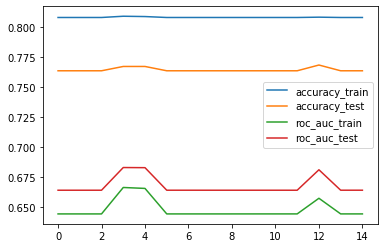

In [24]:
results_logreg.plot()

In [25]:
logreg_final0 = LogisticRegression(solver="liblinear", random_state=42, intercept_scaling= 1.1).fit(X_train, y_train)

## Drugi model – klasyfikator oparty na algorytmie najbliższych sąsiadów 

In [26]:
from sklearn.neighbors import KNeighborsClassifier

In [27]:
results_knn = {metric : [] for metric in metrics}
ind = list(range(2,20))
for i in ind:
    knn = KNeighborsClassifier(n_neighbors = i, weights = 'distance').fit(X_train, y_train)
    results_knn["accuracy_train"].append(accuracy_score(y_train, knn.predict(X_train)))
    results_knn["accuracy_test"].append(accuracy_score(y_val, knn.predict(X_val)))
    results_knn["roc_auc_train"].append(roc_auc_score(y_train, knn.predict_proba(X_train)[:,1]))
    results_knn["roc_auc_test"].append(roc_auc_score(y_val, knn.predict_proba(X_val)[:,1]))

In [28]:
results_knn = pd.DataFrame(results_knn, index = ind)
results_knn

,accuracy_train,accuracy_test,roc_auc_train,roc_auc_test
2,1.0,0.756595,1.0,0.650878
3,1.0,0.775779,1.0,0.669745
4,1.0,0.775779,1.0,0.690150
5,1.0,0.790168,1.0,0.696899
6,1.0,0.791367,1.0,0.697125
7,1.0,0.797362,1.0,0.700846
8,1.0,0.792566,1.0,0.701965
9,1.0,0.802158,1.0,0.708594
10,1.0,0.799760,1.0,0.718533
11,1.0,0.797362,1.0,0.719922


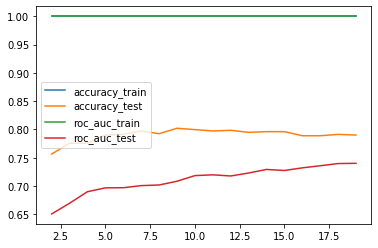

In [29]:
results_knn.plot()

In [30]:
knn_final0 = KNeighborsClassifier(n_neighbors = 8, weights = 'distance').fit(X_train, y_train)

## Trzeci model – las losowy

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
results_rf = {metric : [] for metric in metrics}
ind = list(range(2,20))
for i in ind:
    rf = RandomForestClassifier(max_depth=i, random_state=42).fit(X_train, y_train)
    results_rf["accuracy_train"].append(accuracy_score(y_train, rf.predict(X_train)))
    results_rf["accuracy_test"].append(accuracy_score(y_val, rf.predict(X_val)))
    results_rf["roc_auc_train"].append(roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]))
    results_rf["roc_auc_test"].append(roc_auc_score(y_val, rf.predict_proba(X_val)[:,1]))

In [33]:
results_rf = pd.DataFrame(results_rf, index = ind)
results_rf

,accuracy_train,accuracy_test,roc_auc_train,roc_auc_test
2,0.809757,0.767386,0.833025,0.828065
3,0.823696,0.775779,0.887853,0.828552
4,0.847961,0.787770,0.894181,0.847676
5,0.862932,0.803357,0.908440,0.856012
6,0.886164,0.811751,0.943183,0.899670
7,0.895457,0.818945,0.946072,0.877928
8,0.911977,0.836930,0.960948,0.902734
9,0.925142,0.836930,0.970665,0.905880
10,0.931079,0.851319,0.979999,0.896066
11,0.942953,0.854916,0.986165,0.916531


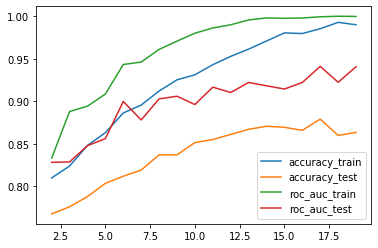

In [34]:
results_rf.plot()

In [35]:
rf_final0 = RandomForestClassifier(max_depth=13, random_state=42).fit(X_train, y_train)

### Strategia 2 – usuwanie braków danych

In [36]:
hmeq_nonan = hmeq.dropna()

In [37]:
X = hmeq_nonan.iloc[:, 1:]
y = hmeq_nonan.loc[:, "BAD"]

In [38]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.35, random_state=42)
X_val1, X_test1, y_val1, y_test1 = train_test_split(X_test1, y_test1, test_size=0.6, random_state=42)

In [39]:
X_train, X_val = X_train1, X_val1
y_train, y_val = y_train1, y_val1

In [40]:
metrics = ["accuracy_train", "accuracy_test", "roc_auc_train", "roc_auc_test"]

## Pierwszy model - regresja logistyczna

In [41]:
from sklearn.linear_model import LogisticRegression

In [42]:
results_logreg = {metric : [] for metric in metrics}
ind = list(range(15))
for i in ind:
    logreg = LogisticRegression(solver="liblinear", random_state=42, intercept_scaling= 1+0.1*i).fit(X_train, y_train)
    results_logreg["accuracy_train"].append(accuracy_score(y_train, logreg.predict(X_train)))
    results_logreg["accuracy_test"].append(accuracy_score(y_val, logreg.predict(X_val)))
    results_logreg["roc_auc_train"].append(roc_auc_score(y_train, logreg.predict_proba(X_train)[:,1]))
    results_logreg["roc_auc_test"].append(roc_auc_score(y_val, logreg.predict_proba(X_val)[:,1]))

In [43]:
results_logreg = pd.DataFrame(results_logreg, index = ind)
results_logreg

,accuracy_train,accuracy_test,roc_auc_train,roc_auc_test
0,0.916813,0.890244,0.656409,0.563462
1,0.916813,0.890244,0.668625,0.590014
2,0.915061,0.890244,0.678168,0.596694
3,0.916813,0.890244,0.656382,0.563377
4,0.915937,0.888211,0.698482,0.636606
5,0.914623,0.890244,0.691364,0.623922
6,0.915061,0.890244,0.679528,0.602275
7,0.916813,0.890244,0.656427,0.563420
8,0.915061,0.890244,0.676710,0.600753
9,0.915061,0.890244,0.694661,0.631744


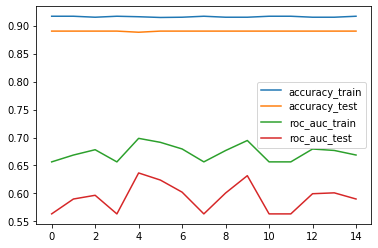

In [44]:
results_logreg.plot()

In [45]:
logreg_final1 = LogisticRegression(solver="liblinear", random_state=42, intercept_scaling= 1.3).fit(X_train, y_train)

## Drugi model – klasyfikator oparty na algorytmie najbliższych sąsiadów 

In [46]:
from sklearn.neighbors import KNeighborsClassifier

In [47]:
results_knn = {metric : [] for metric in metrics}
ind = list(range(2,20))
for i in ind:
    knn = KNeighborsClassifier(n_neighbors = i, weights = 'distance').fit(X_train, y_train)
    results_knn["accuracy_train"].append(accuracy_score(y_train, knn.predict(X_train)))
    results_knn["accuracy_test"].append(accuracy_score(y_val, knn.predict(X_val)))
    results_knn["roc_auc_train"].append(roc_auc_score(y_train, knn.predict_proba(X_train)[:,1]))
    results_knn["roc_auc_test"].append(roc_auc_score(y_val, knn.predict_proba(X_val)[:,1]))

In [48]:
results_knn = pd.DataFrame(results_knn, index = ind)
results_knn

,accuracy_train,accuracy_test,roc_auc_train,roc_auc_test
2,1.0,0.867886,1.0,0.592677
3,1.0,0.888211,1.0,0.597265
4,1.0,0.898374,1.0,0.594812
5,1.0,0.898374,1.0,0.614303
6,1.0,0.900407,1.0,0.619694
7,1.0,0.898374,1.0,0.627642
8,1.0,0.898374,1.0,0.642462
9,1.0,0.894309,1.0,0.640939
10,1.0,0.894309,1.0,0.642863
11,1.0,0.892276,1.0,0.635866


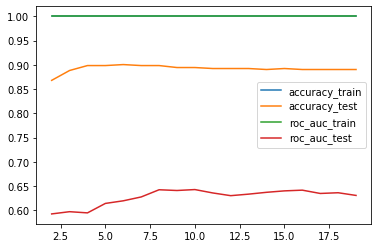

In [49]:
results_knn.plot()

In [50]:
knn_final1 = KNeighborsClassifier(n_neighbors = 8, weights = 'distance').fit(X_train, y_train)

## Trzeci model – las losowy

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
results_rf = {metric : [] for metric in metrics}
ind = list(range(2,20))
for i in ind:
    rf = RandomForestClassifier(max_depth=i, random_state=42).fit(X_train, y_train)
    results_rf["accuracy_train"].append(accuracy_score(y_train, rf.predict(X_train)))
    results_rf["accuracy_test"].append(accuracy_score(y_val, rf.predict(X_val)))
    results_rf["roc_auc_train"].append(roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]))
    results_rf["roc_auc_test"].append(roc_auc_score(y_val, rf.predict_proba(X_val)[:,1]))

In [53]:
results_rf = pd.DataFrame(results_rf, index = ind)
results_rf

,accuracy_train,accuracy_test,roc_auc_train,roc_auc_test
2,0.918126,0.892276,0.807495,0.781033
3,0.937391,0.910569,0.833299,0.791117
4,0.943958,0.912602,0.867325,0.793020
5,0.945709,0.914634,0.865331,0.807606
6,0.947898,0.910569,0.906912,0.814434
7,0.952715,0.914634,0.918356,0.824772
8,0.957093,0.918699,0.936910,0.804266
9,0.957968,0.920732,0.949336,0.863669
10,0.960158,0.920732,0.962473,0.867834
11,0.965412,0.920732,0.978324,0.891341


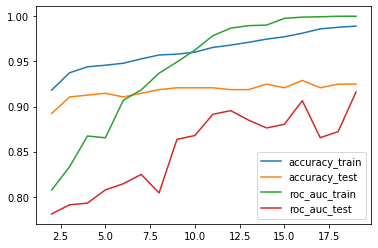

In [54]:
results_rf.plot()

In [55]:
rf_final1 = RandomForestClassifier(max_depth=11, random_state=42).fit(X_train, y_train)

## Sprawdzenie na zbiorze testowym

In [56]:
results = {metric : {} for metric in ["accuracy_test", "roc_auc_test"]}
clf0 = {"LogReg+imputed_nan" : logreg_final0, "KNN+imputed_nan" : knn_final0, "RF+imputed_nan" : rf_final0}
clf1 = {"LogReg+dropped_nan" : logreg_final1, "KNN+dropped_nan" : knn_final1, "RF+dropped_nan" : rf_final1}
for b, c in clf0.items():
    results["accuracy_test"][b] = (accuracy_score(y_test0, c.predict(X_test0)))
    results["roc_auc_test"][b] = (roc_auc_score(y_test0, c.predict_proba(X_test0)[:,1]))
for b, c in clf1.items():
    results["accuracy_test"][b] = (accuracy_score(y_test1, c.predict(X_test1)))
    results["roc_auc_test"][b] = (roc_auc_score(y_test1, c.predict_proba(X_test1)[:,1]))

In [57]:
results = pd.DataFrame(results)

In [58]:
results

,accuracy_test,roc_auc_test
LogReg+imputed_nan,0.794728,0.664498
KNN+imputed_nan,0.816294,0.697491
RF+imputed_nan,0.867412,0.873709
LogReg+dropped_nan,0.912043,0.681671
KNN+dropped_nan,0.912043,0.618683
RF+dropped_nan,0.941813,0.895652


## Podsumowanie

Porównując dwie strategie radzenia sobie z brakami danych, 
zwyczajne ich usuwanie wydaje się mieć przewagę nad próbą uzupełnienia ich średnią – tak przynajmniej
wynika z modeli regresji logistycznej oraz lasów losowych, które lepiej sobie radzą w tym przypadku. 
Wynik klasyfikatora opartego na algorytmie najbliższych sąsiadów nie jest jednoznaczny.


Najlepszym modelem okazały się być lasy losowe.